# Zillow Regression Project

* By Chenchen feng

## Project Goals

* The goal is by analyzing 2017 single family property transaction data from Zillow, find the key drivers of property value for single family properties.

## Project Description

* In this report, we will analyze the Zillow 2017 single family property transaction data, use regression machine learning method to develop a model to have a better prediction on the house value base on the selected features. Then give out the recommandations about how to improve the predictions for the future.

## Initial Questions

1. Does bedroom count affect the house value?

2. Does bathroom count affect the house value?

3. Is there a relationship between fips and house value?

4. Is there a relationship building year and house value?

5. Is there a linear relationship between square feet and house value?

## Data Dictionary

Variables are used in this analysis:

* bedroom : Number of bedrooms in home.
* bathroom : Number of bathrooms in home including fractional bathrooms.
* fips : Federal Information Processing Standard code.
* yearbuilt: The Year the principal residence was built.
* square_ft : Calculated total finished living area of the home.
* house_value : The total tax assessed value of the parcel.
* taxamount : The total property tax assessed for that assessment year.

## Wrangle Zillow Data  (aquire_zillow + prepare_zillow)

### To acquire the Zillow data, I used Zillow.properties_2017 database from MySQL server.

* select bedroom, bathroom, square_feet, fips, yearbuilt, house_value and tax amount from zillow.properties_2017
* left join zillow.predictions_2017 and select transaction date in 2017
* then choose prepertylandusetypeid = 261 which is single family properties

### To clean the data, I did flowing steps:

1. Convert data type: convert bedroom yearbuilt, square_ft and fips into.
2. Drop the null values: percentage of null value is only 0.4%.
3. Set up a cut off line as: bedroom <= 6, bathroom <= 6, house_value < 2,000,000.

In [79]:
import pandas as pd
import env
import os

In [2]:
def get_connection(db, username=env.username, host=env.host, password=env.password):
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'

In [3]:
def get_new_zillow_data():
    
    sql = '''
    select 
    bedroomcnt as bedroom,bathroomcnt as bathroom, calculatedfinishedsquarefeet as square_ft,yearbuilt, fips,
    taxvaluedollarcnt as house_value, taxamount as tax
    FROM zillow.properties_2017
    left join zillow.predictions_2017 using (parcelid)
    WHERE propertylandusetypeid = 261 and transactiondate like "2017%%"
    '''
    
    return pd.read_sql(sql, get_connection('zillow'))

In [509]:
import acquire_zillow
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math

In [510]:
raw_data = acquire_zillow.get_new_zillow_data()
df = raw_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedroom      52441 non-null  float64
 1   bathroom     52441 non-null  float64
 2   square_ft    52359 non-null  float64
 3   yearbuilt    52325 non-null  float64
 4   fips         52441 non-null  float64
 5   house_value  52440 non-null  float64
 6   tax          52437 non-null  float64
dtypes: float64(7)
memory usage: 2.8 MB


In [291]:
df.head()

,bedroom,bathroom,square_ft,yearbuilt,fips,house_value,tax
0,4.0,3.5,3100.0,1998.0,6059.0,1023282.0,11013.72
1,2.0,1.0,1465.0,1967.0,6111.0,464000.0,5672.48
2,3.0,2.0,1243.0,1962.0,6059.0,564778.0,6488.30
3,4.0,3.0,2376.0,1970.0,6037.0,145143.0,1777.51
4,4.0,3.0,2962.0,1950.0,6037.0,773303.0,9516.26


In [82]:
df.isnull().sum()

bedroom          0
bathroom         0
square_ft       82
yearbuilt      116
fips             0
house_value      1
tax              4
dtype: int64

In [511]:
df = df.dropna()
df.isnull().sum()

bedroom        0
bathroom       0
square_ft      0
yearbuilt      0
fips           0
house_value    0
tax            0
dtype: int64

In [52]:
# 100% of columns can be converted to int w/o data loss
(df.square_ft == df.square_ft.astype(int)).mean()

1.0

In [53]:
(df.bathroom == df.bathroom.astype(int)).mean()

0.8727898308324572

In [54]:
(df.bedroom == df.bedroom.astype(int)).mean()

1.0

### convert bedroom yearbuilt, square_ft and fips into int

In [512]:
df[['bedroom', 'square_ft','yearbuilt', 'fips']] = df[['bedroom', 'square_ft','yearbuilt', 'fips']].astype('int')
# df[['fips']] = df[['fips']].astype('object')

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedroom      52315 non-null  int64  
 1   bathroom     52315 non-null  float64
 2   square_ft    52315 non-null  int64  
 3   yearbuilt    52315 non-null  int64  
 4   fips         52315 non-null  int64  
 5   house_value  52315 non-null  float64
 6   tax          52315 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.2 MB


### handling outlies

In [86]:
df.square_ft.sort_values(ascending=False).head(10)

4864     21929
16571    20612
5740     18654
48495    17245
28105    15450
43724    14829
27017    13598
14558    12616
49045    12056
2789     12039
Name: square_ft, dtype: int64

In [90]:
df[df.square_ft <= 6000].shape[0] / df.shape[0]

0.9932141833126255

In [91]:
df[df.square_ft >= 6000].house_value.mean()

4421848.359550562

In [23]:
df.bedroom.value_counts()

3     23346
4     15226
2      8333
5      3970
6       633
1       605
7       106
0        57
8        24
9         8
12        3
10        2
14        1
11        1
Name: bedroom, dtype: int64

In [100]:
df[df.bedroom <= 6].shape[0] / df.shape[0]

0.9972283283952977

In [24]:
df.bathroom.value_counts()

2.0     21887
3.0     10664
1.0      9552
2.5      3931
4.0      2227
3.5       913
1.5       840
5.0       803
4.5       682
6.0       322
5.5       224
7.0        88
8.0        53
6.5        47
0.0        41
7.5        16
9.0        13
10.0        5
11.0        3
8.5         2
18.0        1
13.0        1
Name: bathroom, dtype: int64

In [101]:
df[df.bathroom <= 6].shape[0] / df.shape[0]

0.9956226703622288

In [138]:
df[df.house_value < 2000000].shape[0] / df.shape[0]

0.9737360221733729

In [102]:
df.shape

(52315, 7)

In [513]:
df = df[df.bedroom <= 6]

df = df[df.bathroom <= 6]

df = df[df.house_value < 2000000]

In [265]:
df.shape

(50789, 7)

bedroom


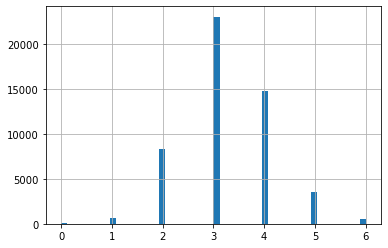

bathroom


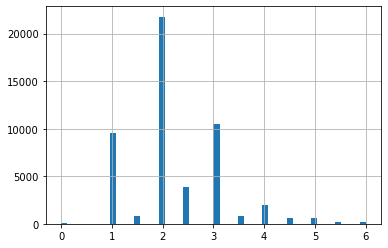

square_ft


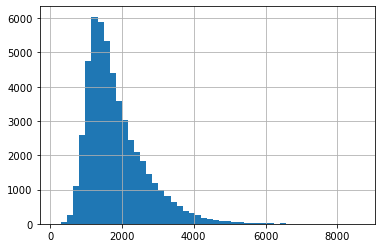

yearbuilt


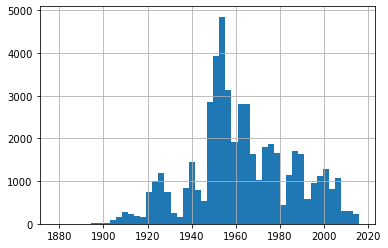

fips


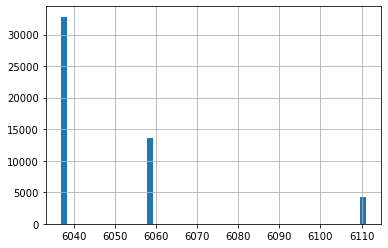

house_value


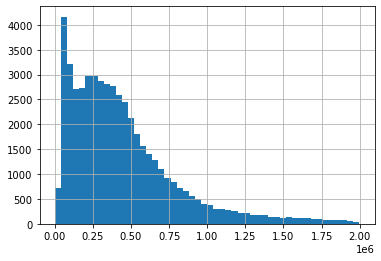

tax


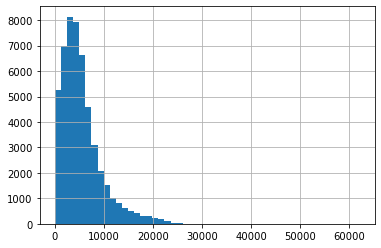

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in df.columns:
    print(col)
    df[col].hist(bins=50)
    plt.show()

### drop the outlies: square_ft > 6000, bathroom > 6 and bedroom > 6

In [ ]:
def clean_zillow():
    df = df.dropna()
    df[['bedroom', 'square_ft','yearbuilt', 'fips']] = df[['bedroom', 'square_ft','yearbuilt', 'fips']].astype('int')
    
    df = df[df.bedroom <= 6]
    df = df[df.bathroom <= 6]
    df = df[df.house_value < 2000000]
    
    return df

In [142]:
# create a function to wrangle zillow data:

def wrangle_zillow():
    raw_data = acquire_zillow.get_new_zillow_data()
    df = raw_data.copy()
    df = df.dropna()
    df[['bedroom', 'square_ft','yearbuilt']] = df[['bedroom', 'square_ft','yearbuilt']].astype('int')
    df[['fips']] = df[['fips']].astype('object')
    
    df = df[df.bedroom <= 6]
    df = df[df.bathroom <= 6]
    df = df[df.house_value < 2000000]
    
    return df

In [144]:
# test the function
df1 = wrangle_zillow()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50789 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedroom      50789 non-null  int64  
 1   bathroom     50789 non-null  float64
 2   square_ft    50789 non-null  int64  
 3   yearbuilt    50789 non-null  int64  
 4   fips         50789 non-null  object 
 5   house_value  50789 non-null  float64
 6   tax          50789 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 3.1+ MB


In [327]:
# split data

train_and_validate, test = train_test_split(df, test_size=0.2, random_state=123)
train, validate = train_test_split(train_and_validate, test_size=0.3, random_state=123)

In [328]:
train.shape, validate.shape, test.shape

((28441, 7), (12190, 7), (10158, 7))

In [ ]:
def split_zillow(df):
    
    train_and_validate, test = train_test_split(df, test_size=0.2, random_state=123)
    train, validate = train_test_split(train_and_validate, test_size=0.3, random_state=123)
    
    return train, validate, test

## Data Context

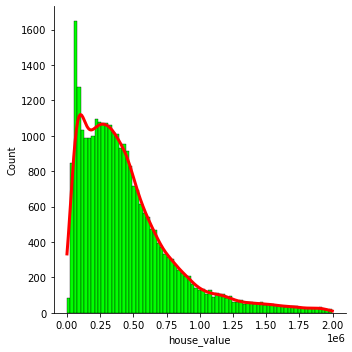

In [515]:
sns.displot(x = 'house_value', data = train, kde=True, color='red',
            line_kws={'lw': 3}, facecolor='lime', edgecolor='black')

<AxesSubplot:xlabel='house_value', ylabel='Count'>

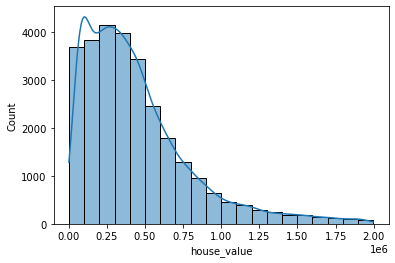

In [514]:
sns.histplot(x = 'house_value', bins = 20, data = train, kde=True)

<AxesSubplot:xlabel='fips', ylabel='count'>

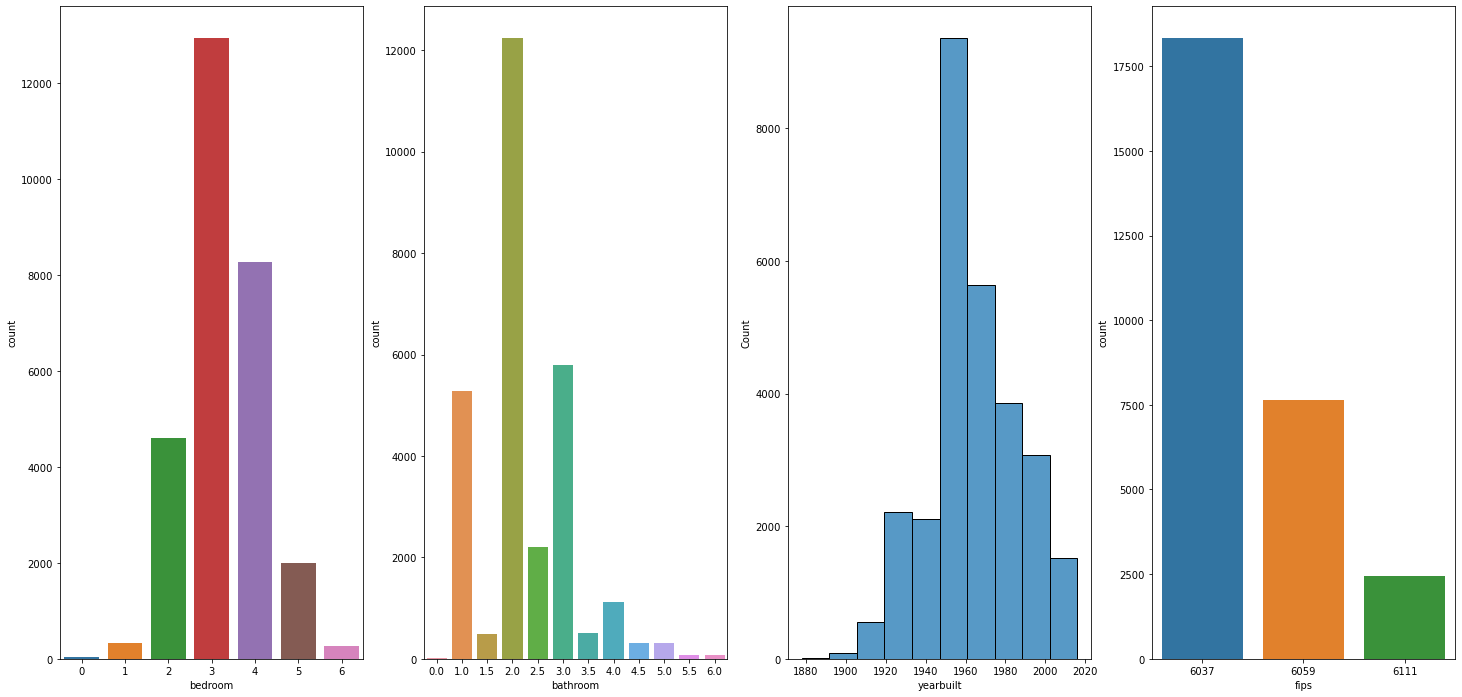

In [516]:
figure, axes = plt.subplots(1,4, figsize=(25,12))
    
sns.countplot(x='bedroom', data=train, ax=axes[0])
sns.countplot(x='bathroom', data=train, ax=axes[1])
sns.histplot(x='yearbuilt', bins = 10, data=train, ax=axes[2])
sns.countplot(x='fips', data=train, ax=axes[3])

# Exploration Data (on train set)

In [147]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

### * relationship between house value and bedroom, bathroom, fips

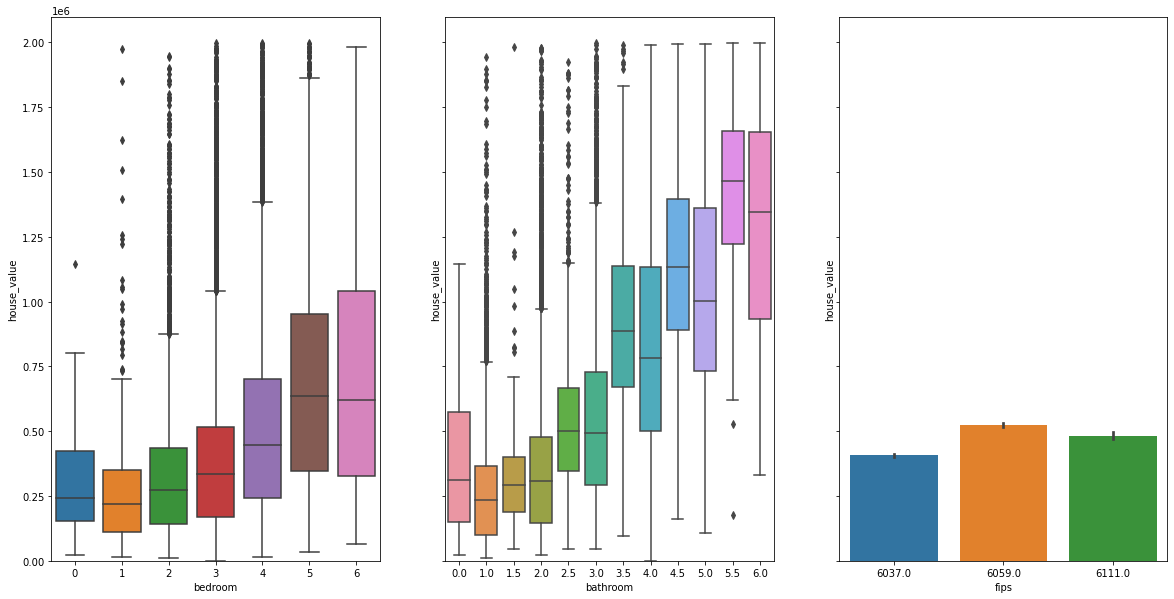

In [148]:
figure, axes = plt.subplots(1,3, sharey = True, figsize=(20,10))
    
sns.boxplot(x='bedroom', y='house_value', data=train, ax=axes[0])
sns.boxplot(x='bathroom', y='house_value', data=train, ax=axes[1])
sns.barplot(x='fips', y='house_value', data=train, ax=axes[2])

plt.show()

In [503]:
train.groupby('fips').house_value.mean()

fips
6037    406496.199106
6059    524572.073356
6111    483373.120325
Name: house_value, dtype: float64

In [504]:
train.fips.value_counts()

6037    18347
6059     7634
6111     2460
Name: fips, dtype: int64

In [508]:
pd.DataFrame({'fips': [6037, 6059, 6111],
              'county name': ['Los Angeles, CA', 'Orange, CA', 'Ventura, CA'],
             'Average house value': [406496, 524572, 483373],
             'percentage of home count': [0.65, 0.27, 0.08]})

,fips,county name,Average house value,percentage of home count
0,6037,"Los Angeles, CA",406496,0.65
1,6059,"Orange, CA",524572,0.27
2,6111,"Ventura, CA",483373,0.08


* house value increases with bedroom counts and bathroom counts
* when bathroom count > 2, the half bathroom house value is higher then full bath
* fips number 6059 has the highest house value, then 6111, then 6037

### * relationship between house value and yearbuilt and suqre feet

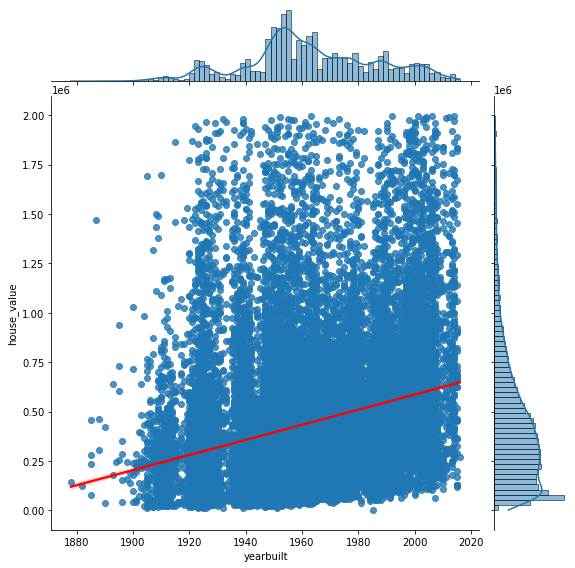

In [152]:
sns.jointplot(x='yearbuilt', y='house_value', data=train, kind='reg', line_kws={'color': 'red'}, height=8)

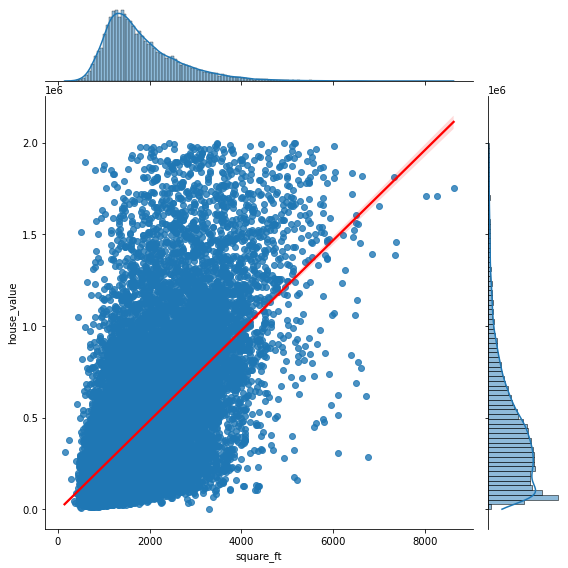

In [157]:
sns.jointplot("square_ft", "house_value", data=train, kind='reg', line_kws={'color': 'red'},height=8)

* The house value increases with built year and square feet

### Statistic Test for square feet, year built, bedroom and bathroom

In [158]:
# square feet

r, p_value = pearsonr(train.square_ft, train.house_value)
print(f'Correlation Coefficient by Pearson Test: {r}, p-value: {p_value}')

# set alpha : 0.05
if p_value < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

Correlation Coefficient by Pearson Test: 0.5751863413849152, p-value: 0.0
We can reject the null hypothesis


In [159]:
# yearbuilt

r, p_value = pearsonr(train.yearbuilt, train.house_value)
print(f'Correlation Coefficient by Pearson Test: {r}, p-value: {p_value}')

# set alpha : 0.05
if p_value < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

Correlation Coefficient by Pearson Test: 0.24615026349629532, p-value: 0.0
We can reject the null hypothesis


In [160]:
# bathroom

r, p_value = pearsonr(train.bathroom, train.house_value)
print(f'Correlation Coefficient by Pearson Test: {r}, p-value: {p_value}')

# set alpha : 0.05
if p_value < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

Correlation Coefficient by Pearson Test: 0.5059406210390505, p-value: 0.0
We can reject the null hypothesis


In [161]:
# bedroom

r, p_value = pearsonr(train.bedroom, train.house_value)
print(f'Correlation Coefficient by Pearson Test: {r}, p-value: {p_value}')

# set alpha : 0.05
if p_value < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

Correlation Coefficient by Pearson Test: 0.275041838330826, p-value: 0.0
We can reject the null hypothesis


In [311]:
train_sample_corr = train.corr(method='pearson')
train_sample_corr

,bedroom,bathroom,square_ft,yearbuilt,fips,house_value,tax
bedroom,1.000000,0.631978,0.629571,0.396960,0.150663,0.275042,0.277939
bathroom,0.631978,1.000000,0.828338,0.549147,0.127648,0.505941,0.509496
square_ft,0.629571,0.828338,1.000000,0.490245,0.144451,0.575186,0.575026
yearbuilt,0.396960,0.549147,0.490245,1.000000,0.295265,0.246150,0.260797
fips,0.150663,0.127648,0.144451,0.295265,1.000000,0.095237,0.046643
house_value,0.275042,0.505941,0.575186,0.246150,0.095237,1.000000,0.970493
tax,0.277939,0.509496,0.575026,0.260797,0.046643,0.970493,1.000000


<AxesSubplot:>

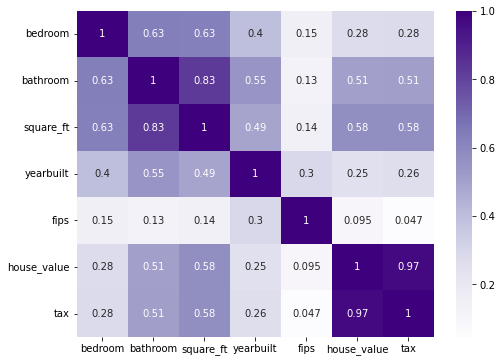

In [312]:
plt.figure(figsize=(8,6))
correlation_table = train.corr()
sns.heatmap(correlation_table, cmap='Purples', annot=True)

### top three features:
* bathroom = 0.51
* square_feet = 0.58
* bedroom = 0.28

## Exploration Summary:

* Bathroom number and square feet haave the strongest relationship with house value, therefore, I will use those two features for my modeling.

# Predicting House Value for Zillow

(array([7529., 8132., 5898., 3076., 1595.,  861.,  522.,  371.,  265.,
         192.]),
 array([1.0000000e+03, 2.0062510e+05, 4.0025020e+05, 5.9987530e+05,
        7.9950040e+05, 9.9912550e+05, 1.1987506e+06, 1.3983757e+06,
        1.5980008e+06, 1.7976259e+06, 1.9972510e+06]),
 <BarContainer object of 10 artists>)

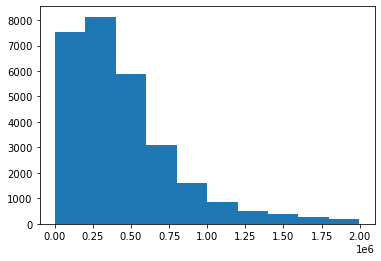

In [329]:
#Visualize my target variable
plt.hist(train.house_value)

In [330]:
#Establish baselines for the train and validation subsets
from math import sqrt
from sklearn.metrics import mean_squared_error

baseline = train.house_value.mean()

train['baseline'] = baseline
validate['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train.house_value, train.baseline))
validate_rmse = sqrt(mean_squared_error(validate.house_value, validate.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 354300.374389348.
Validation baseline RMSE: 347942.07118664036.


In [332]:
train.head()

,bedroom,bathroom,square_ft,yearbuilt,fips,house_value,tax,baseline
8365,3,2.0,1605,1983,6111,206483.0,2293.70,444839.029886
46472,2,1.0,1521,1970,6037,110048.0,1530.47,444839.029886
45202,3,2.0,1678,1956,6059,82423.0,1175.02,444839.029886
1123,3,1.5,1126,1955,6059,373151.0,4521.78,444839.029886
14047,4,6.0,5158,2002,6037,1430885.0,17415.28,444839.029886


In [397]:
x_train = train.drop(columns=['house_value','tax', 'yearbuilt', 'fips', 'baseline'])
y_train = train[['house_value']]

x_validate = validate.drop(columns=['house_value','tax', 'yearbuilt', 'fips', 'baseline'])
y_validate = validate[['house_value']]

x_test = test.drop(columns=['house_value','tax', 'yearbuilt', 'fips'])
y_test = test[['house_value']]

In [398]:
x_train.head()

,bedroom,bathroom,square_ft
8365,3,2.0,1605
46472,2,1.0,1521
45202,3,2.0,1678
1123,3,1.5,1126
14047,4,6.0,5158


In [399]:
# scale the data

mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(x_train[['bedroom','bathroom','square_ft']])

x_train[['bedroom','bathroom','square_ft']] = mms.transform(x_train[['bedroom','bathroom','square_ft']])

x_validate[['bedroom','bathroom','square_ft']] = mms.transform(x_validate[['bedroom','bathroom','square_ft']])

x_test[['bedroom','bathroom','square_ft']] = mms.transform(x_test[['bedroom','bathroom','square_ft']])

In [400]:
x_train.head()

,bedroom,bathroom,square_ft
8365,0.500000,0.333333,0.171689
46472,0.333333,0.166667,0.161763
45202,0.500000,0.333333,0.180314
1123,0.500000,0.250000,0.115089
14047,0.666667,1.000000,0.591516


In [401]:
y_train.head()

,house_value
8365,206483.0
46472,110048.0
45202,82423.0
1123,373151.0
14047,1430885.0


In [480]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [489]:
predictions_train = pd.DataFrame({'actual': train.house_value})
predictions_train['baseline'] = baseline

predictions_validate = pd.DataFrame({'actual': validate.house_value})
predictions_validate['baseline'] = baseline

predictions_train.head()

,actual,baseline
8365,206483.0,444839.029886
46472,110048.0,444839.029886
45202,82423.0,444839.029886
1123,373151.0,444839.029886
14047,1430885.0,444839.029886


In [490]:
# #Instantiate the linear regression model and fit it to the data
lm = LinearRegression()

lm.fit(x_train, y_train)

predictions_train['lm'] = lm.predict(x_train)

predictions_validate['lm'] = lm.predict(x_validate)

predictions_train.head()

,actual,baseline,lm
8365,206483.0,444839.029886,3.919516e+05
46472,110048.0,444839.029886,3.792310e+05
45202,82423.0,444839.029886,4.093239e+05
1123,373151.0,444839.029886,2.474018e+05
14047,1430885.0,444839.029886,1.413567e+06


In [491]:
predictions_validate.head()

,actual,baseline,lm
5077,1113996.0,444839.029886,369819.729432
11398,212737.0,444839.029886,412179.638771
38479,279131.0,444839.029886,277008.692117
1893,347304.0,444839.029886,378635.011919
49406,385902.0,444839.029886,736499.788630


In [492]:
#Instantiate lars and fit
lars = LassoLars(alpha=1.0)

lars.fit(x_train, y_train)

predictions_train['lasso_lars'] = lars.predict(x_train)

predictions_validate['lasso_lars'] = lars.predict(x_validate)

predictions_train.head()

,actual,baseline,lm,lasso_lars
8365,206483.0,444839.029886,3.919516e+05,3.919465e+05
46472,110048.0,444839.029886,3.792310e+05,3.789890e+05
45202,82423.0,444839.029886,4.093239e+05,4.092956e+05
1123,373151.0,444839.029886,2.474018e+05,2.476994e+05
14047,1430885.0,444839.029886,1.413567e+06,1.411794e+06


In [468]:
predictions_validate.head()

,actual,baseline,lm,lasso_lars
5077,1113996.0,444839.029886,369819.729432,369844.188248
11398,212737.0,444839.029886,412179.638771,412147.551673
38479,279131.0,444839.029886,277008.692117,277157.043665
1893,347304.0,444839.029886,378635.011919,379011.208187
49406,385902.0,444839.029886,736499.788630,735815.436641


In [493]:
#Instantiate TweedieRegressor and fit
glm = TweedieRegressor(power=0, alpha=1)

glm.fit(x_train, y_train)

predictions_train['glm'] = glm.predict(x_train)

predictions_validate['glm'] = glm.predict(x_validate)

predictions_train.head()

,actual,baseline,lm,lasso_lars,glm
8365,206483.0,444839.029886,3.919516e+05,3.919465e+05,442674.494722
46472,110048.0,444839.029886,3.792310e+05,3.789890e+05,435904.706906
45202,82423.0,444839.029886,4.093239e+05,4.092956e+05,442840.965185
1123,373151.0,444839.029886,2.474018e+05,2.476994e+05,439432.804839
14047,1430885.0,444839.029886,1.413567e+06,1.411794e+06,470251.270127


In [470]:
predictions_validate.head()

,actual,baseline,lm,lasso_lars,glm
5077,1113996.0,444839.029886,369819.729432,369844.188248,442462.415914
11398,212737.0,444839.029886,412179.638771,412147.551673,442868.330192
38479,279131.0,444839.029886,277008.692117,277157.043665,441573.053170
1893,347304.0,444839.029886,378635.011919,379011.208187,447338.240467
49406,385902.0,444839.029886,736499.788630,735815.436641,449689.211718


In [494]:
# Polynomial degree 2

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

poly.fit(x_train)

x_train_poly = pd.DataFrame(
    poly.transform(x_train),
    columns=poly.get_feature_names(x_train.columns),
    index=train.index)

lm1 = LinearRegression()
lm1.fit(x_train_poly, y_train)
x_train_poly = poly.transform(x_train)

predictions_train['polynomial_degree_2'] = lm1.predict(x_train_poly)

predictions_validate['polynomial_degree_2'] = lm1.predict(poly.transform(x_validate))

predictions_train.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2
8365,206483.0,444839.029886,3.919516e+05,3.919465e+05,442674.494722,3.862114e+05
46472,110048.0,444839.029886,3.792310e+05,3.789890e+05,435904.706906,3.878962e+05
45202,82423.0,444839.029886,4.093239e+05,4.092956e+05,442840.965185,4.039454e+05
1123,373151.0,444839.029886,2.474018e+05,2.476994e+05,439432.804839,2.550158e+05
14047,1430885.0,444839.029886,1.413567e+06,1.411794e+06,470251.270127,1.642342e+06


In [495]:
predictions_validate.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2
5077,1113996.0,444839.029886,369819.729432,369844.188248,442462.415914,363215.185210
11398,212737.0,444839.029886,412179.638771,412147.551673,442868.330192,406833.931327
38479,279131.0,444839.029886,277008.692117,277157.043665,441573.053170,261854.380565
1893,347304.0,444839.029886,378635.011919,379011.208187,447338.240467,363090.814257
49406,385902.0,444839.029886,736499.788630,735815.436641,449689.211718,729046.061385


In [496]:
# polynomial only interaction

poly1 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

poly1.fit(x_train)

x_train_poly1 = pd.DataFrame(
    poly1.transform(x_train),
    columns=poly1.get_feature_names(x_train.columns),
    index=train.index)

lm1.fit(x_train_poly1, y_train)
x_train_poly1 = poly1.transform(x_train)

predictions_train['polynomial_only_interaction'] = lm1.predict(x_train_poly1)

predictions_validate['polynomial_only_interaction'] = lm1.predict(poly1.transform(x_validate))

predictions_train.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
8365,206483.0,444839.029886,3.919516e+05,3.919465e+05,442674.494722,3.862114e+05,3.868983e+05
46472,110048.0,444839.029886,3.792310e+05,3.789890e+05,435904.706906,3.878962e+05,3.826682e+05
45202,82423.0,444839.029886,4.093239e+05,4.092956e+05,442840.965185,4.039454e+05,4.032066e+05
1123,373151.0,444839.029886,2.474018e+05,2.476994e+05,439432.804839,2.550158e+05,2.586623e+05
14047,1430885.0,444839.029886,1.413567e+06,1.411794e+06,470251.270127,1.642342e+06,1.569138e+06


In [497]:
predictions_validate.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
5077,1113996.0,444839.029886,369819.729432,369844.188248,442462.415914,363215.185210,366121.948669
11398,212737.0,444839.029886,412179.638771,412147.551673,442868.330192,406833.931327,405887.400008
38479,279131.0,444839.029886,277008.692117,277157.043665,441573.053170,261854.380565,278995.397983
1893,347304.0,444839.029886,378635.011919,379011.208187,447338.240467,363090.814257,377241.526156
49406,385902.0,444839.029886,736499.788630,735815.436641,449689.211718,729046.061385,727022.773529


## evaluate on the train set with RMSE (Root Mean Squared Error)

In [498]:
predictions_train.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
8365,206483.0,444839.029886,3.919516e+05,3.919465e+05,442674.494722,3.862114e+05,3.868983e+05
46472,110048.0,444839.029886,3.792310e+05,3.789890e+05,435904.706906,3.878962e+05,3.826682e+05
45202,82423.0,444839.029886,4.093239e+05,4.092956e+05,442840.965185,4.039454e+05,4.032066e+05
1123,373151.0,444839.029886,2.474018e+05,2.476994e+05,439432.804839,2.550158e+05,2.586623e+05
14047,1430885.0,444839.029886,1.413567e+06,1.411794e+06,470251.270127,1.642342e+06,1.569138e+06


In [499]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_train.actual, y_predicted))

predictions_train.apply(calculate_rmse).sort_values()

actual                              0.000000
polynomial_degree_2            284486.095617
polynomial_only_interaction    285074.050248
lm                             285551.721745
lasso_lars                     285552.028073
glm                            350756.070828
baseline                       354300.374389
dtype: float64

In [501]:
# The r2_score function computes the coefficient of determination

def calculate_r2(y_predicted):
    return r2_score(predictions_train.actual, y_predicted)

predictions_train.apply(calculate_r2).sort_values()

baseline                       0.000000
glm                            0.019907
lasso_lars                     0.350428
lm                             0.350429
polynomial_only_interaction    0.352601
polynomial_degree_2            0.355269
actual                         1.000000
dtype: float64

## evaluate on the validate set

In [477]:
predictions_validate.head()

,actual,baseline,lm,lasso_lars,glm,polynomial degree 2,polynomial only interaction
5077,1113996.0,444839.029886,369819.729432,369844.188248,442462.415914,363215.185210,366121.948669
11398,212737.0,444839.029886,412179.638771,412147.551673,442868.330192,406833.931327,405887.400008
38479,279131.0,444839.029886,277008.692117,277157.043665,441573.053170,261854.380565,278995.397983
1893,347304.0,444839.029886,378635.011919,379011.208187,447338.240467,363090.814257,377241.526156
49406,385902.0,444839.029886,736499.788630,735815.436641,449689.211718,729046.061385,727022.773529


In [478]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_validate.actual, y_predicted))

predictions_validate.apply(calculate_rmse).sort_values()

actual                              0.000000
polynomial degree 2            280522.236177
polynomial only interaction    280852.130795
lasso_lars                     281616.009393
lm                             281616.658281
glm                            344467.556654
baseline                       347942.071187
dtype: float64

## Evaluate on Test: Best Model (2nd Degree Polynomial)

In [534]:
# re-create our polynomial model
poly_test = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly_test.fit(x_train)
x_train_poly = pd.DataFrame(poly_test.transform(x_train),
                            columns=poly.get_feature_names(x_train.columns),index=train.index)

lm_test = LinearRegression()
lm_test.fit(x_train_poly, y_train)

LinearRegression()

In [535]:
# any transformations applied to your training data must be applied to the test as well

x_test_poly = poly_test.transform(x_test)

test_predictions = lm_test.predict(x_test_poly)
test_actual = test.house_value

In [536]:
# RMSE

sqrt(mean_squared_error(test_actual, test_predictions))

289424.54758118454

In [520]:
print('RMSE for 2nd Degree Polynomial model on the train dataset: 284486.10')
print('RMSE for 2nd Degree Polynomial model on the validate dataset: 280522.24')
print('RMSE for 2nd Degree Polynomial model on the test dataset: 289424.55')

RMSE for 2nd Degree Polynomial model on the train dataset: 284486.10
RMSE for 2nd Degree Polynomial model on the validate dataset: 280522.24
RMSE for 2nd Degree Polynomial model on the test dataset: 289424.55


In [487]:
print('RMSE for 2nd Degree Polynomial model on the test dataset: {}'.format(sqrt(mean_squared_error(test_actual, test_predictions))))

RMSE for 2nd Degree Polynomial model on the test dataset: 289424.54758118454


Text(0, 0.5, '\nPredicted Value Error\n')

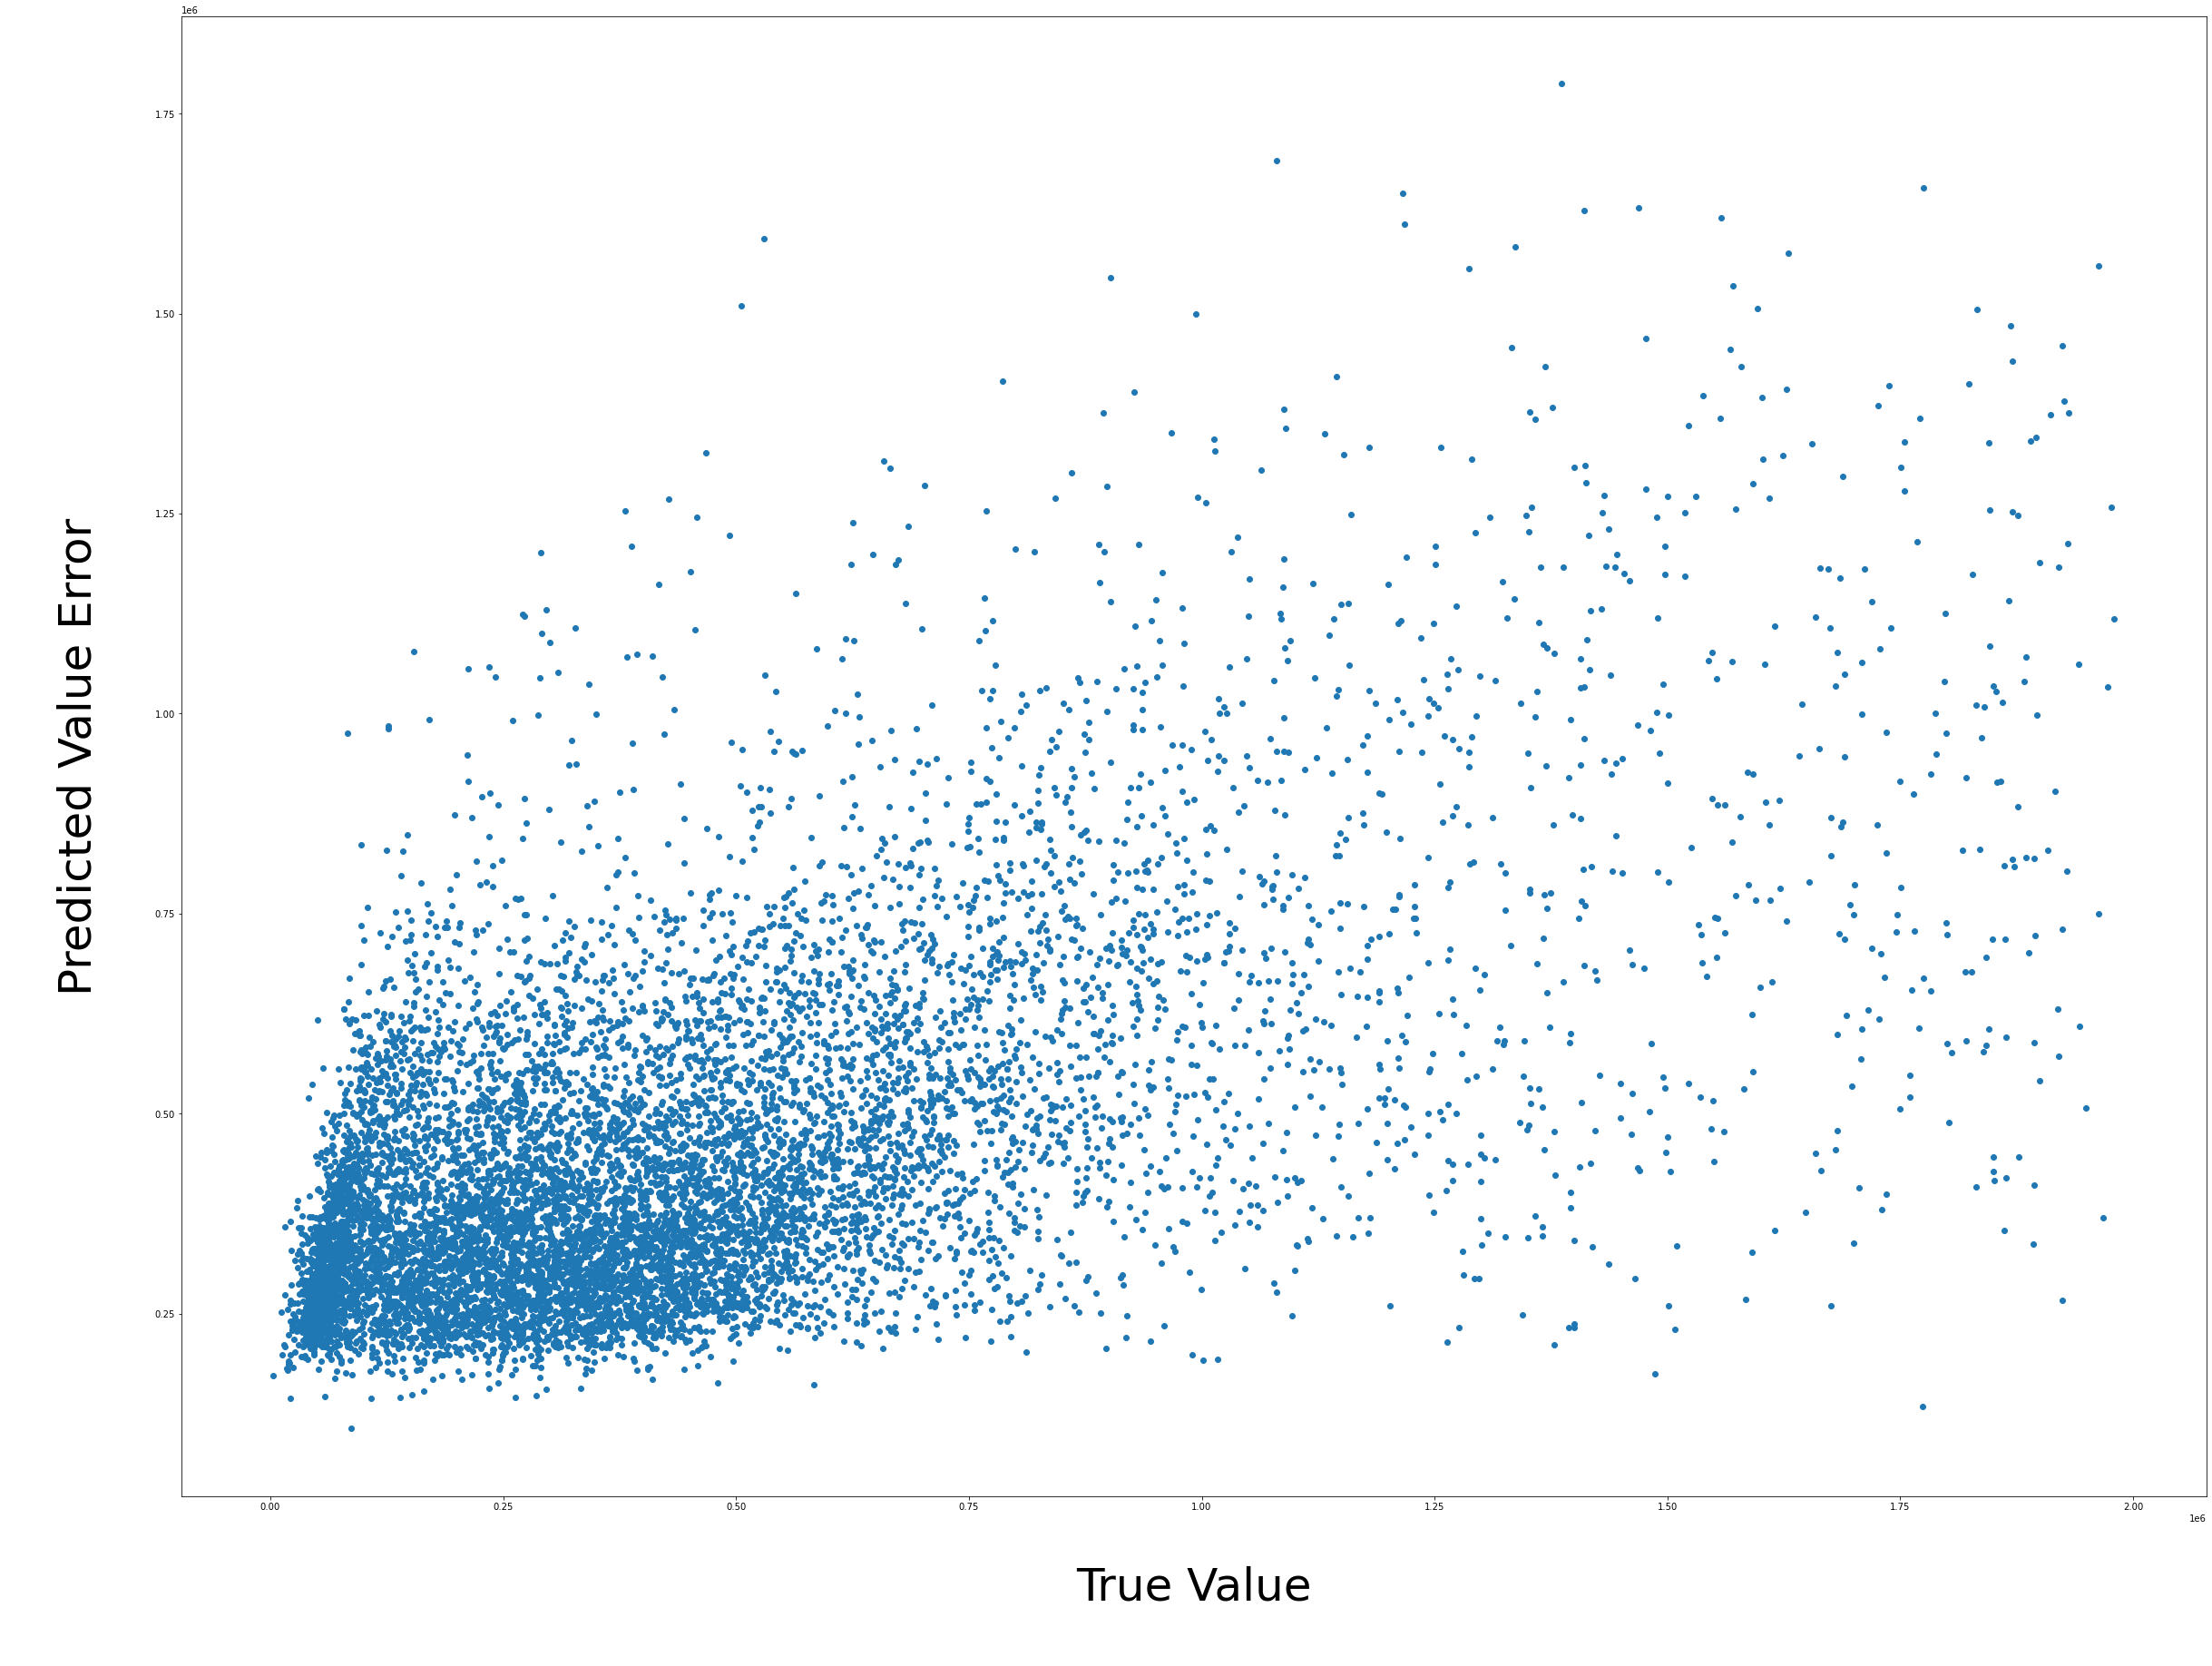

In [525]:
plt.figure(figsize=(40, 30))
plt.scatter(test_actual, test_predictions)
plt.xlabel('\nTrue Value\n', fontsize=50)
plt.ylabel('\nPredicted Value Error\n', fontsize=50)

Text(0.5, 1.0, 'Actual tip vs predicted tip across all models')

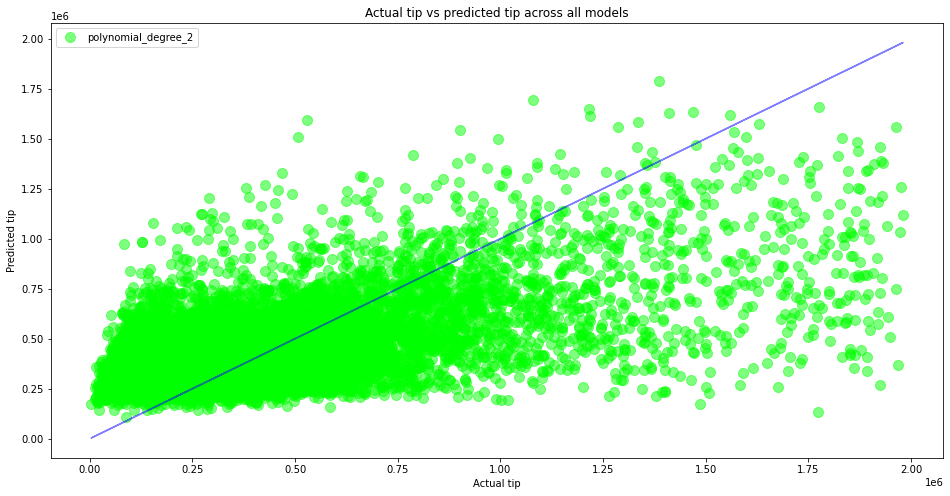

In [551]:
plt.figure(figsize=(16,8))

plt.plot(predictions_test['actual'], predictions_test['actual'], alpha=0.5,
         color='blue', label='_nolegend_')

plt.scatter(predictions_test['actual'], predictions_test['polynomial_degree_2'], alpha=0.5,
            color='lime', s=100, label='polynomial_degree_2')

plt.legend()
plt.xlabel('Actual tip')
plt.ylabel('Predicted tip')
plt.title('Actual tip vs predicted tip across all models')

In [544]:
predictions_test

,actual,polynomial_degree_2
47277,373443.0,614337.412777
18166,83206.0,279040.398316
405,421527.0,296261.692166
33081,129764.0,314308.409946
29514,188643.0,230319.080670
...,...,...
15357,705551.0,841265.107349
5569,103722.0,248556.899878
33905,133447.0,190232.668376
42163,47617.0,358458.315419


In [527]:
test_actual

47277    373443.0
18166     83206.0
405      421527.0
33081    129764.0
29514    188643.0
           ...   
15357    705551.0
5569     103722.0
33905    133447.0
42163     47617.0
17639    160047.0
Name: house_value, Length: 10158, dtype: float64

In [540]:
predictions_test = pd.DataFrame({'actual': test.house_value})

In [541]:
predictions_test

,actual
47277,373443.0
18166,83206.0
405,421527.0
33081,129764.0
29514,188643.0
...,...
15357,705551.0
5569,103722.0
33905,133447.0
42163,47617.0


In [542]:
predictions_test['polynomial_degree_2'] = lm_test.predict(poly_test.transform(x_test))

In [543]:
predictions_test[]

,actual,polynomial_degree_2
47277,373443.0,614337.412777
18166,83206.0,279040.398316
405,421527.0,296261.692166
33081,129764.0,314308.409946
29514,188643.0,230319.080670
...,...,...
15357,705551.0,841265.107349
5569,103722.0,248556.899878
33905,133447.0,190232.668376
42163,47617.0,358458.315419


In [ ]:
# train = pd.get_dummies(train, ['fips'])
# validate = pd.get_dummies(validate, ['fips'])
# train.head()

## Feature engineering

In [214]:
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
import sklearn.preprocessing

In [211]:
train.head()

,bedroom,bathroom,square_ft,yearbuilt,fips,house_value,tax
8365,3,2.0,1605,1983,6111.0,206483.0,2293.70
46472,2,1.0,1521,1970,6037.0,110048.0,1530.47
45202,3,2.0,1678,1956,6059.0,82423.0,1175.02
1123,3,1.5,1126,1955,6059.0,373151.0,4521.78
14047,4,6.0,5158,2002,6037.0,1430885.0,17415.28


In [212]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28441 entries, 8365 to 46891
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedroom      28441 non-null  int64  
 1   bathroom     28441 non-null  float64
 2   square_ft    28441 non-null  int64  
 3   yearbuilt    28441 non-null  int64  
 4   fips         28441 non-null  object 
 5   house_value  28441 non-null  float64
 6   tax          28441 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 2.7+ MB


In [236]:
train.head()

,bedroom,bathroom,square_ft,yearbuilt,fips,house_value,tax
8365,3,2.0,1605,1983,6111.0,206483.0,2293.70
46472,2,1.0,1521,1970,6037.0,110048.0,1530.47
45202,3,2.0,1678,1956,6059.0,82423.0,1175.02
1123,3,1.5,1126,1955,6059.0,373151.0,4521.78
14047,4,6.0,5158,2002,6037.0,1430885.0,17415.28


In [239]:
x_train = train[['bedroom','bedroom','bathroom','square_ft','yearbuilt', 'fips']]
y_train = train.house_value

x_validate = validate[['bedroom','bedroom','bathroom','square_ft','yearbuilt', 'fips']]
y_validate = validate.house_value

x_test = test[['bedroom','bedroom','bathroom','square_ft','yearbuilt', 'fips']]
y_test = test.house_value

In [ ]:
# first we need to get dummies for fips

train = pd.get_dummies(train, ['fips'])

In [221]:
# then scale the train set

scaler = sklearn.preprocessing.MinMaxScaler()

cols_to_scale = ['bedroom','bathroom','square_ft','yearbuilt']

scaler.fit(train[cols_to_scale])

train_scaled = scaler.transform(train[cols_to_scale])
validate_scaled = scaler.transform(validate[cols_to_scale])
test_scaled = scaler.transform(test[cols_to_scale])

In [226]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled = train_scaled.rename(columns = {0 :'bedroom_scaled',1 :'bathroom_scaled', 2 : 'square_ft_scaled',
                                             3 : 'yearbuilt_scaled'})
train_scaled.head()

,bedroom_scaled,bathroom_scaled,square_ft_scaled,yearbuilt_scaled
0,0.500000,0.333333,0.171689,0.760870
1,0.333333,0.166667,0.161763,0.666667
2,0.500000,0.333333,0.180314,0.565217
3,0.500000,0.250000,0.115089,0.557971
4,0.666667,1.000000,0.591516,0.898551


In [224]:
train_scaled = train_scaled.set_index([train.index.values])

AttributeError: 'numpy.ndarray' object has no attribute 'set_index'

In [235]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28441 entries, 8365 to 46891
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedroom      28441 non-null  int64  
 1   bathroom     28441 non-null  float64
 2   square_ft    28441 non-null  int64  
 3   yearbuilt    28441 non-null  int64  
 4   fips         28441 non-null  object 
 5   house_value  28441 non-null  float64
 6   tax          28441 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 1.7+ MB
